In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/LSTM/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/LSTM


In [0]:
def display_dp(dp):
    for line in dp:
        print(str(line) + "\n")

def get_string_alignment(sent_1, sent_2):
    penalty_space = 1 ##insertion/deletion err weight
    penalty_sub = 1 ##subsititution err weight

    sentence_1_arr = sent_1.split(" ")
    sentence_2_arr = sent_2.split(" ")

    num_sent_1 = len(sentence_1_arr) + 1
    num_sent_2 = len(sentence_2_arr) + 1

    dp_matrix = [[0 for i in range(num_sent_2)] for j in range(num_sent_1)]

    for row in range(0, num_sent_1):
        for col in range(0, num_sent_2):
            if row == 0 or col == 0:
                dp_matrix[row][col] = (row + col) * penalty_space
            else:
                if sentence_1_arr[row-1] ==  sentence_2_arr[col-1]:
                    dp_matrix[row][col] = min(dp_matrix[row-1][col-1], penalty_space + min(dp_matrix[row-1][col], dp_matrix[row][col-1]))
                else:
                    dp_matrix[row][col] = min(penalty_sub + dp_matrix[row-1][col-1], penalty_space + min(dp_matrix[row-1][col], dp_matrix[row][col-1]))

    # display_dp(dp_matrix)

    aligned_sent_1 = []
    aligned_sent_2 = []
    row = num_sent_1 - 1
    col = num_sent_2 - 1

    while row != 0 and col != 0:
        if sentence_1_arr[row - 1] == sentence_2_arr[col - 1] and dp_matrix[row][col] == dp_matrix[row - 1][col - 1]:
            aligned_sent_1.insert(0, sentence_1_arr[row -1])
            aligned_sent_2.insert(0, sentence_2_arr[col - 1])
            row -= 1
            col -= 1
        elif sentence_1_arr[row - 1] != sentence_2_arr[col - 1] and  dp_matrix[row][col] == (dp_matrix[row - 1][col - 1] + penalty_sub):
            aligned_sent_1.insert(0, sentence_1_arr[row - 1])
            aligned_sent_2.insert(0, sentence_2_arr[col - 1])
            row -= 1
            col -= 1
        elif dp_matrix[row][col] == (dp_matrix[row][col - 1] + penalty_space):
            aligned_sent_1.insert(0, "_")
            aligned_sent_2.insert(0, sentence_2_arr[col - 1])
            col -= 1
        elif dp_matrix[row][col] == (dp_matrix[row - 1][col] + penalty_space):
            aligned_sent_1.insert(0, sentence_1_arr[row - 1])
            aligned_sent_2.insert(0, "_")
            row -= 1

    while row > 0 or col > 0:
        if row > 0:
            aligned_sent_1.insert(0, sentence_1_arr[row - 1])
            aligned_sent_2.insert(0, "_")
            row -= 1
        else:
            aligned_sent_1.insert(0, "_")
            aligned_sent_2.insert(0, sentence_2_arr[col - 1])
            col -= 1
    
    return aligned_sent_1, aligned_sent_2

Word Correctness = 0.7330508474576272 Deletion = 0.06779661016949153 Substitution = 0.18220338983050846 Insertion = 0.01694915254237288
Sentence Correctness = 0.44642857142857145


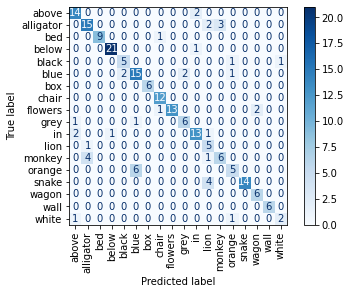

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

user = "Ravi"

result_file = "results/" + user + "/" + "results.txt"
res = open(result_file, 'r')

prediction = ""
ground_truth = ""

prediction_words = []
gt_words = []
vocab = set()

H,D,S,I,N = 0,0,0,0,0

sen_corr, sen_tot = 0,0

for i in res:
    if i.startswith("Predicted"):
        prediction = i.split(":  ")[1]
    if i.startswith("True"):
        ground_truth = i.split(":  ")[1]
        pred_align, gt_align = get_string_alignment(prediction, ground_truth)
        
        if prediction == ground_truth:
            sen_corr += 1            
        sen_tot += 1

        for index in range(len(pred_align)):
            if pred_align[index] != "sil0" and pred_align[index] != "sil1\n":
                N += 1
                if pred_align[index] == gt_align[index]:
                    H += 1
                    prediction_words.append(pred_align[index])
                    gt_words.append(gt_align[index])
                    vocab.add(pred_align[index])
                elif pred_align[index] == "_":
                    D += 1
                elif gt_align[index] == "_":
                    I += 1
                else:
                    prediction_words.append(pred_align[index])
                    gt_words.append(gt_align[index])
                    vocab.add(pred_align[index])
                    vocab.add(gt_words[index])
                    S += 1

vocab = [i for i in vocab]
vocab.sort()

print("Word Correctness = " + str(H/N) + " Deletion = " + str(D/N) + " Substitution = " + str(S/N) + " Insertion = " + str(I/N))
print("Sentence Correctness = " + str(sen_corr/sen_tot))

matrix = ConfusionMatrixDisplay(confusion_matrix(gt_words, prediction_words, labels=vocab), vocab)
matrix.plot(cmap='Blues', xticks_rotation='vertical')